# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA


# Classifier ---------------------------------------
# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV # regressor 응용
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# Regressor-----------------------------------------
# estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------

# stats : R module
from scipy.stats import skew, kurtosis

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------

## metrics

In [2]:
# # classification cross_validate : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # estimators=
# classification_models = [RandomForestClassifier(random_state=0),
#                          GradientBoostingClassifier(random_state=0),
#                          XGBClassifier(random_state=0),
#                          XGBRFClassifier(random_state=0),
#                          LGBMClassifier(random_state=0),
#                          CatBoostClassifier(random_state=0),
#                          ]

# # scorings=
# classification_scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#                           'precision':'precision_macro', 'recall':'recall_macro', 
#                           'roc_auc_ovr':'roc_auc_ovr',}

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cross_validate loop
# for model in classification_models:
    
#     cv_results = cross_validate(model, X_met, y_met,
#                                 scoring=classification_scorers,
#                                 cv=skf,
#                                 return_train_score=True, return_estimator=True)
    
#     print('-' * 70)
#     print('model  =', model.__class__.__name__)
#     print('params =', model.get_params(deep=True))
    
#     # classification metrics
#     print('f1_macro  = {}  '.format(cv_results['test_f1_macro'].mean()),
#           'accuracy  = {}  '.format(cv_results['test_accuracy'].mean()), '\n'
#           'precision = {}  '.format(cv_results['test_precision'].mean()),
#           'recall    = {}  '.format(cv_results['test_recall'].mean()), '\n'
#           'AUC_ovr   = {}  '.format(cv_results['test_roc_auc_ovr'].mean()),
#           )
    
#     fi_list = []
#     for idx, estimator in enumerate(cv_results['estimator']):
#         fi = pd.DataFrame(estimator.feature_importances_, 
#                           index=X_met.columns, columns=['importance']).sort_values('importance', ascending=False)
        
#         fi_list.append(estimator.feature_importances_.tolist())
#     fi_means = np.array(fi_list).mean(axis=0)
#     fi_df = pd.DataFrame(fi_means, columns=['importance'], index=X_met.columns).sort_values(by='importance', ascending=False)
#     fig, ax = plt.subplots(figsize=(16, 12))
#     sns.set_theme(style='whitegrid')
#     sns.set_color_codes('pastel')
#     sns.barplot(x='importance', y_met=X_met.columns, data=fi_df)
#     plt.show()

In [3]:
# # classification GridsearchCV : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # models
# classification_models = [RandomForestClassifier(),
#                          GradientBoostingClassifier(),
#                          XGBClassifier(), 
#                          XGBRFClassifier(), 
#                          LGBMClassifier(), 
#                          CatBoostClassifier(),
#                          ]

# # param_grid=
# hyper_param = {'n_estimators':[100],
#                'random_state':[0],
#               #  'min_samples_split':[2],
#               #  'min_samples_leaf':[1],
#                }

# # scoring=
# classification_scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#                           'precision':'precision_macro', 'recall':'recall_macro', 
#                           'roc_auc_ovr':'roc_auc_ovr',}

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cv_results_ cols
# classification_cols = ['mean_test_f1_macro', 'mean_test_accuracy', 
#                        'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# # GridSearchCV loop
# for model in classification_models:
        
#         gscv = GridSearchCV(model, param_grid=hyper_param, 
#                             scoring=classification_scorers, refit='f1_macro', 
#                             cv=skf, return_train_score=True)
#         gscv.fit(X_met, y_met)
#         results = gscv.cv_results_
        
#         print('-' * 75)
#         print('estimtor        =', gscv.estimator)
#         print('best_params_    =', gscv.best_params_)
#         print('best_score_     =', gscv.best_score_)
        
#         met_df = pd.DataFrame(results)[classification_cols]
#         met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
#         print(met_df)

In [4]:
# # regression cross_validate : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # estimators=
# regressor_models = [
#                     # LinearRegression(),
#                     # RandomForestRegressor(random_state=0),
#                     Ridge(random_state=0),
#                     Lasso(random_state=0),
#                     ElasticNet(random_state=0),
#                     DecisionTreeRegressor(random_state=0),
#                     XGBRegressor(random_state=0),
#                     LGBMRegressor(random_state=0),
#                     # CatBoostRegressor(random_state=0),
#                     ]

# # scorings=
# regressor_scorers = {'MSE':'neg_mean_squared_error',
#                      'RMSE':'neg_root_mean_squared_error',
#                     #  'MSLE':'neg_mean_squared_log_error',
#                     #  'MAE':'neg_mean_absolute_error',
#                      }

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cross_validate loop
# for model in regressor_models:
    
#     cv_results = cross_validate(model, X_met, y_met,
#                                 scoring=regressor_scorers,
#                                 cv=kf,
#                                 return_train_score=True, return_estimator=True)
    
#     print('-' * 40)
#     print('model  =', model.__class__.__name__)
#     # print('params =', model.get_params(deep=True))
    
#     # regression metrics
#     print('MSE    = {}  '.format(- cv_results['test_MSE'].mean()), '\n'
#           'RMSE   =  {}  '.format(- cv_results['test_RMSE'].mean()),
#         #   'MSLE   = {}  '.format(- cv_results['test_MSLE'].mean()),
#         #   'MAE    = {}  '.format(- cv_results['test_MAE'].mean()),
#           )

In [5]:
# # regression GridsearchCV : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # models
# regressor_models = [
#                     # LinearRegression(),
#                     # RandomForestRegressor(),
#                     Ridge(),
#                     Lasso(),
#                     ElasticNet(),
#                     DecisionTreeRegressor(),
#                     XGBRegressor(),
#                     LGBMRegressor(),
#                     # CatBoostRegressor(),
#                     ]

# # param_grid=
# hyper_param = {
#                'random_state':[0],
#                }

# # scoring=
# regressor_scorers = {'MSE':'neg_mean_squared_error',
#                      'RMSE':'neg_root_mean_squared_error',
#                     #  'MSLE':'neg_mean_squared_log_error',
#                     #  'MAE':'neg_mean_absolute_error',
#                      }

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cv_results_ cols
# regression_cols = ['mean_test_MSE', 'mean_test_RMSE', 
#                 #    'mean_test_MSLE', 'mean_test_MAE',
#                    ]

# # GridSearchCV loop
# for model in regressor_models:
        
#         gscv = GridSearchCV(model, 
#                             param_grid=hyper_param, 
#                             scoring=regressor_scorers, refit='RMSE', 
#                             cv=kf, return_train_score=True)
#         gscv.fit(X_met, y_met)
#         results = gscv.cv_results_
        
#         print('-' * 40)
#         print('estimtor        =', gscv.estimator.__class__.__name__)
#         print('best_params_    =', gscv.best_params_)
#         print('best_score_     =', - gscv.best_score_)
        
#         met_df = pd.DataFrame(results)[regression_cols]
#         met_df.columns = ['MSE', 'RMSE', 
#                         #   'MSLE', 'MAE',
#                           ]
#         print(- met_df)

# regression

In [6]:
# https://www.kaggle.com/vikrishnan/boston-house-prices?
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

# feature description
# crim	  자치시(town)별 1인당 범죄율
# zn	  25,000 평방 피트를 초과하는 거주지역의 비율
# indus	  비소매상업지역이 차지하고 있는 토지의 비율
# chas	  찰스강의 경계에 위치한 경우는 1, 아니면 0
# nox	  10ppm 당 농축 일산화질소
# rm	  주택 1가구당 평균 방의 수
# age	  1940년 이전에 건축한 소유주택 비율
# dis	  보스톤 직업센터까지의 접근성 지수
# rad	  방사형 도로까지의 접근성 지수
# tax	  10,000 달러당 재산세율
# ptratio 자치시(town)별 학생/교사 비율
# b       자치시(town)별 흑인의 비율
# lstat	  모집단의 하위 계층의 비율
# medv	  본인 소유의 주택가격 중앙값(단위 $1000)

In [7]:
df.shape

(506, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [9]:
outlier_idx = df[(df['CRIM']>60) | (df['B']<150)].index
df = df.drop(index=outlier_idx, axis=0)
df.shape

(468, 14)

In [10]:
df = df.reset_index(drop=True)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [11]:
df00 = np.log1p(df)

In [12]:
scaler = StandardScaler()

df00 = pd.DataFrame(scaler.fit_transform(df00), columns=df.columns)
df00.shape

(468, 14)

In [13]:
type(df00)

pandas.core.frame.DataFrame

In [14]:
# regression cross_validate : INPUT DF VERSION & TARGET
# ==================================================
df_met     = df00
target_met = 'target'
# ==================================================

# X, y split
train_met = df_met[df_met[target_met].notna()]
# train_met = df_met
X_met = train_met.drop(target_met, axis=1)
y_met = train_met[target_met]

# estimators=
regressor_models = [
                    # LinearRegression(),
                    # RandomForestRegressor(random_state=0),
                    # Ridge(random_state=0),
                    # Lasso(random_state=0),
                    # ElasticNet(random_state=0),
                    # DecisionTreeRegressor(random_state=0),
                    XGBRegressor(random_state=0),
                    LGBMRegressor(random_state=0),
                    # CatBoostRegressor(random_state=0),
                    ]

# scorings=
regressor_scorers = {'MSE':'neg_mean_squared_error',
                     'RMSE':'neg_root_mean_squared_error',
                    #  'MSLE':'neg_mean_squared_log_error',
                    #  'MAE':'neg_mean_absolute_error',
                     }

# cv=
kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cross_validate loop
for model in regressor_models:
    
    cv_results = cross_validate(model, X_met, y_met,
                                scoring=regressor_scorers,
                                cv=kf,
                                return_train_score=True, return_estimator=True)
    
    print('-' * 40)
    print('model  =', model.__class__.__name__)
    # print('params =', model.get_params(deep=True))
    
    # regression metrics
    print('MSE    = {}  '.format(- cv_results['test_MSE'].mean()), '\n'
          'RMSE   = {}  '.format(- cv_results['test_RMSE'].mean()),
          # 'MSLE   = {}  '.format(- cv_results['test_MSLE'].mean()),
          # 'MAE    = {}  '.format(- cv_results['test_MAE'].mean()),
          )

----------------------------------------
model  = XGBRegressor
MSE    = 0.15293878156785728   
RMSE   = 0.3882514223020659  
----------------------------------------
model  = LGBMRegressor
MSE    = 0.14856365439239375   
RMSE   = 0.3816674679762245  


# regulations(norms)

In [15]:
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [17]:
y = df['target']
X = df.drop(['target'], axis=1)
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(404, 13) (102, 13) (404,) (102,)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
220,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71
71,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88
240,0.11329,30.0,4.93,0.0,0.428,6.897,54.3,6.3361,6.0,300.0,16.6,391.25,11.38
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
417,25.94060,0.0,18.10,0.0,0.679,5.304,89.1,1.6475,24.0,666.0,20.2,127.36,26.64


In [18]:
models = [Ridge(), Lasso(), ElasticNet()]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{model.__class__.__name__}\t MSE:{mse:.4f} RMSE:{rmse:.4f}")

Ridge	 MSE:34.2316 RMSE:5.8508
Lasso	 MSE:41.7001 RMSE:6.4576
ElasticNet	 MSE:40.6653 RMSE:6.3769


In [19]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

# 회귀모델의 분류 응용
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV

In [20]:
# ridge_model = Ridge(alpha=1.0, 
#                     fit_intercept=True, # bias 조정
#                     normalize=False,    # 정규화
#                     max_iter=None,      # 반복횟수
#                     random_state=None, 
#                     )

# lasso_model = Lasso(alpha=1.0, 
#                     fit_intercept=True, 
#                     normalize=False,
#                     max_iter=1000,
#                     random_state=None, 
#                     )

# elast_model = ElasticNet(alpha=1.0, 
#                          l1_ratio=0.5, 
#                          fit_intercept=True,
#                          normalize=False, 
#                          max_iter=1000,
#                          random_state=None, 
#                          )

In [21]:
# L1
lasso_model = Lasso(alpha=1.0, normalize=False, max_iter=1000, random_state=0)

# L2
ridge_model = Ridge(alpha=1.0, normalize=False, max_iter=1000, random_state=0)

# L1:L2 = r:r-1
elast_model = ElasticNet(alpha=1.0, l1_ratio=0.5, normalize=False, max_iter=1000, random_state=0)

In [22]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
220,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71
71,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88
240,0.11329,30.0,4.93,0.0,0.428,6.897,54.3,6.3361,6.0,300.0,16.6,391.25,11.38
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
417,25.94060,0.0,18.10,0.0,0.679,5.304,89.1,1.6475,24.0,666.0,20.2,127.36,26.64


In [23]:
models = [lasso_model, ridge_model, elast_model]
lasso_model.fit
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(mse, rmse)

41.700096799949 6.457561211475196
34.231606110615374 5.850778248285896
40.6653320776942 6.376937515586475


# alpha & var, bias, w

## L1 : Lasso

--------------------------------------------------
a         = 0
rmse      = 5.783509315085144
intercept = 38.09169492630261
            0        1         2         3          4         5         6   \
cols      CRIM       ZN     INDUS      CHAS        NOX        RM       AGE   
coef -0.119443  0.04478  0.005485  2.340804 -16.123604  3.708709 -0.003121   

            7         8        9         10       11        12  
cols       DIS       RAD      TAX   PTRATIO        B     LSTAT  
coef -1.386397  0.244178 -0.01099 -1.045921  0.00811 -0.492793  


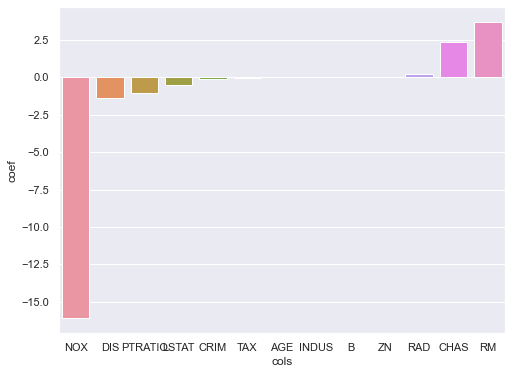

--------------------------------------------------
a         = 0.01
rmse      = 5.813168992331166
intercept = 35.69552389781352
            0         1        2         3          4        5         6   \
cols      CRIM        ZN    INDUS      CHAS        NOX       RM       AGE   
coef -0.117913  0.045351 -0.00715  2.197465 -12.513598  3.71872 -0.006263   

            7        8       9         10        11        12  
cols       DIS      RAD     TAX   PTRATIO         B     LSTAT  
coef -1.330661  0.23416 -0.0113 -1.009793  0.008325 -0.496981  


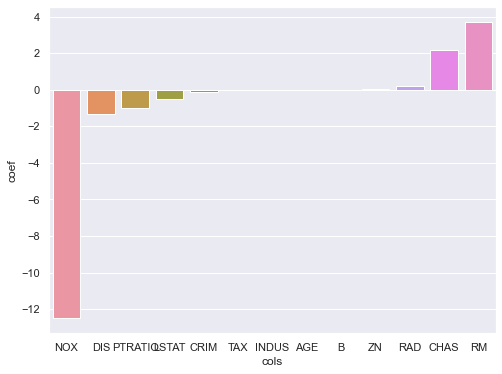

--------------------------------------------------
a         = 0.1
rmse      = 6.006234477237565
intercept = 28.51075639829714
            0         1         2        3    4         5         6   \
cols      CRIM        ZN     INDUS     CHAS  NOX        RM       AGE   
coef -0.111247  0.047784 -0.043241  0.84232 -0.0  3.594824 -0.014483   

            7         8         9         10       11        12  
cols       DIS       RAD       TAX   PTRATIO        B     LSTAT  
coef -1.111749  0.206671 -0.012868 -0.892662  0.00912 -0.525479  


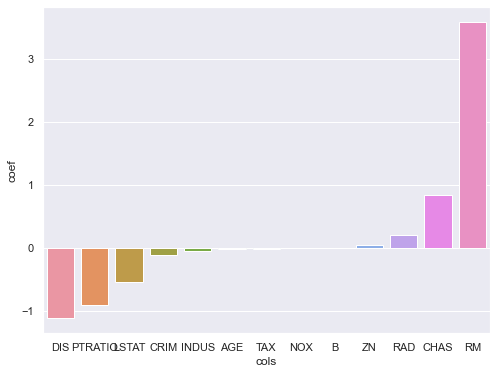

--------------------------------------------------
a         = 1
rmse      = 6.457561211475196
intercept = 45.83126047459114
           0         1      2     3    4        5         6         7   \
cols     CRIM        ZN  INDUS  CHAS  NOX       RM       AGE       DIS   
coef -0.05889  0.053177   -0.0   0.0 -0.0  0.67955  0.016841 -0.648766   

            8         9        10        11       12  
cols       RAD       TAX  PTRATIO         B    LSTAT  
coef  0.198738 -0.013994 -0.86422  0.006603 -0.73121  


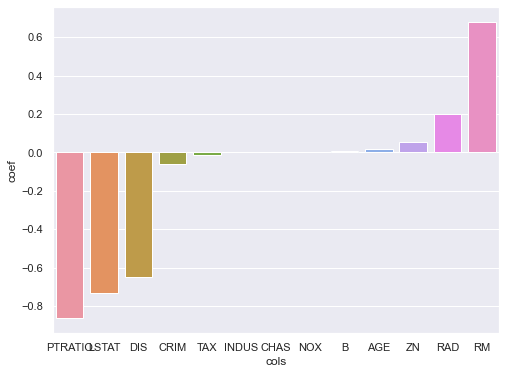

--------------------------------------------------
a         = 1.5
rmse      = 6.701951403103985
intercept = 47.58226768214629
           0        1      2     3    4    5        6         7         8   \
cols     CRIM       ZN  INDUS  CHAS  NOX   RM      AGE       DIS       RAD   
coef -0.03226  0.04903   -0.0   0.0 -0.0  0.0  0.02984 -0.359096  0.157199   

            9         10        11        12  
cols       TAX   PTRATIO         B     LSTAT  
coef -0.012489 -0.799298  0.005705 -0.777773  


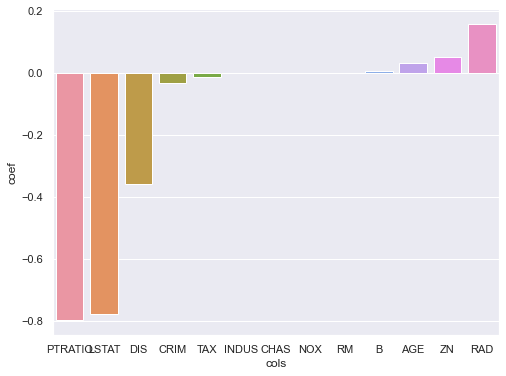

--------------------------------------------------
a         = 2
rmse      = 6.8490730672595905
intercept = 43.77658933324592
            0         1      2     3    4    5         6         7         8   \
cols      CRIM        ZN  INDUS  CHAS  NOX   RM       AGE       DIS       RAD   
coef -0.007755  0.040207   -0.0   0.0 -0.0  0.0  0.039379 -0.035129  0.097647   

            9         10        11        12  
cols       TAX   PTRATIO         B     LSTAT  
coef -0.010125 -0.706703  0.005282 -0.778019  


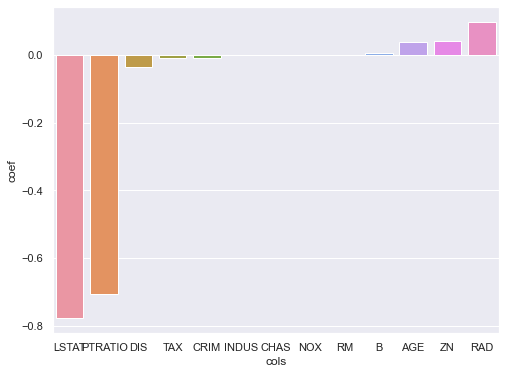

--------------------------------------------------
a         = 2.5
rmse      = 6.919443221874342
intercept = 41.03204423783668
        0         1      2     3    4    5         6    7         8   \
cols  CRIM        ZN  INDUS  CHAS  NOX   RM       AGE  DIS       RAD   
coef  -0.0  0.041403   -0.0   0.0  0.0  0.0  0.039348 -0.0  0.047182   

            9         10        11        12  
cols       TAX   PTRATIO         B     LSTAT  
coef -0.008753 -0.568073  0.004897 -0.772171  


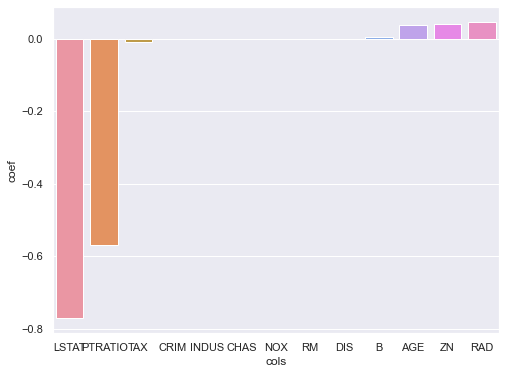

--------------------------------------------------
a         = 3
rmse      = 6.981725237531107
intercept = 38.40997634062012
        0         1      2     3    4    5         6    7         8   \
cols  CRIM        ZN  INDUS  CHAS  NOX   RM       AGE  DIS       RAD   
coef  -0.0  0.043933   -0.0   0.0  0.0  0.0  0.038148 -0.0  0.001588   

            9         10        11        12  
cols       TAX   PTRATIO         B     LSTAT  
coef -0.007543 -0.424557  0.004515 -0.763987  


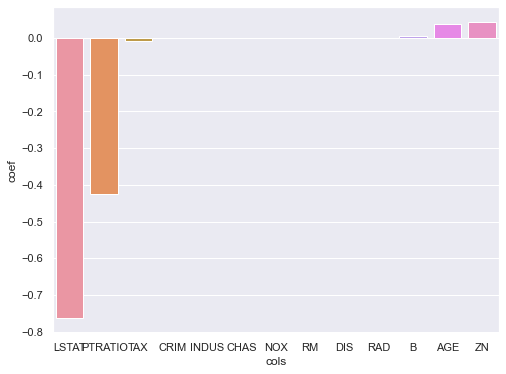

In [24]:
alphas =[0, 0.01, 0.1, 1, 1.5, 2, 2.5, 3]

for a in alphas:
    
    print('-' * 50)
    model = Lasso(alpha=a, normalize=False, max_iter=1000, random_state=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print('a         =', a)
    print('rmse      =', rmse)
    print('intercept =',model.intercept_)
    
    coef = model.coef_  # classification의 feature_importances_
    coef_df = pd.DataFrame({'cols':X_train.columns, 'coef':coef})
    print(coef_df.T)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(data=coef_df.sort_values(by='coef'), x='cols', y='coef')
    plt.show()

## L2 : Ridge

--------------------------------------------------
a         = 0
rmse      = 5.783509315085137
intercept = 38.091694926302694
            0        1         2         3          4         5         6   \
cols      CRIM       ZN     INDUS      CHAS        NOX        RM       AGE   
coef -0.119443  0.04478  0.005485  2.340804 -16.123604  3.708709 -0.003121   

            7         8        9         10       11        12  
cols       DIS       RAD      TAX   PTRATIO        B     LSTAT  
coef -1.386397  0.244178 -0.01099 -1.045921  0.00811 -0.492793  


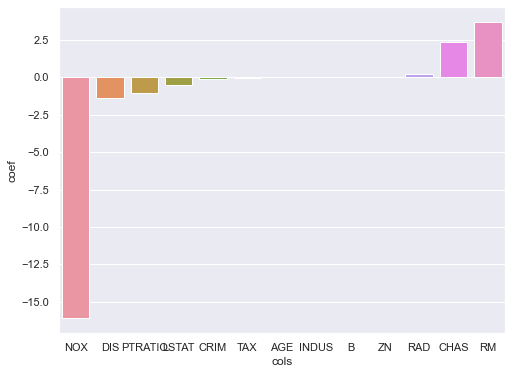

--------------------------------------------------
a         = 0.01
rmse      = 5.784375587883092
intercept = 37.99270527786664
            0         1         2         3          4         5        6   \
cols      CRIM        ZN     INDUS      CHAS        NOX        RM      AGE   
coef -0.119394  0.044801  0.004938  2.340366 -15.982138  3.709885 -0.00326   

          7         8         9        10        11        12  
cols     DIS       RAD       TAX  PTRATIO         B     LSTAT  
coef -1.3844  0.243751 -0.010999 -1.04447  0.008118 -0.492883  


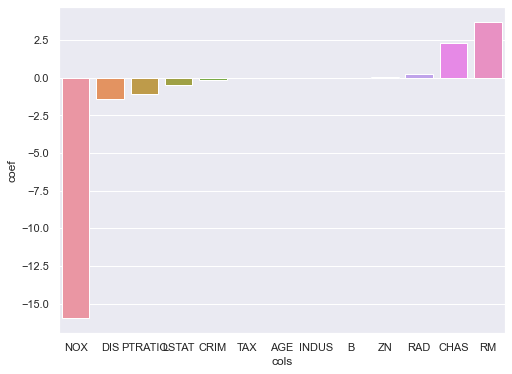

--------------------------------------------------
a         = 0.1
rmse      = 5.792105693607121
intercept = 37.176545457733454
            0         1         2         3          4         5         6   \
cols      CRIM        ZN     INDUS      CHAS        NOX        RM       AGE   
coef -0.118983  0.044977  0.000411  2.336109 -14.812614  3.719342 -0.004407   

          7         8         9         10        11        12  
cols     DIS       RAD       TAX   PTRATIO         B     LSTAT  
coef -1.3679  0.240226 -0.011077 -1.032485  0.008184 -0.493652  


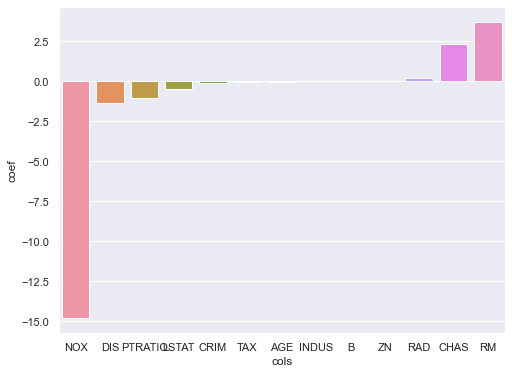

--------------------------------------------------
a         = 1
rmse      = 5.850778248285896
intercept = 32.93620573379918
            0         1         2        3         4         5         6   \
cols      CRIM        ZN     INDUS     CHAS       NOX        RM       AGE   
coef -0.116808  0.046003 -0.023762  2.27815 -8.557796  3.755135 -0.010414   

            7         8         9         10        11        12  
cols       DIS       RAD       TAX   PTRATIO         B     LSTAT  
coef -1.280095  0.222038 -0.011526 -0.969288  0.008535 -0.498849  


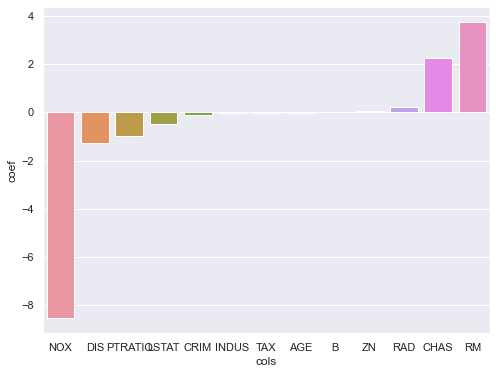

--------------------------------------------------
a         = 1.5
rmse      = 5.870942293101895
intercept = 31.913227678518336
            0         1         2         3         4         5         6   \
cols      CRIM        ZN     INDUS      CHAS       NOX        RM       AGE   
coef -0.116255  0.046324 -0.030022  2.241979 -6.933823  3.755129 -0.011896   

            7        8        9         10        11        12  
cols       DIS      RAD      TAX   PTRATIO         B     LSTAT  
coef -1.257561  0.21772 -0.01166 -0.953432  0.008624 -0.500879  


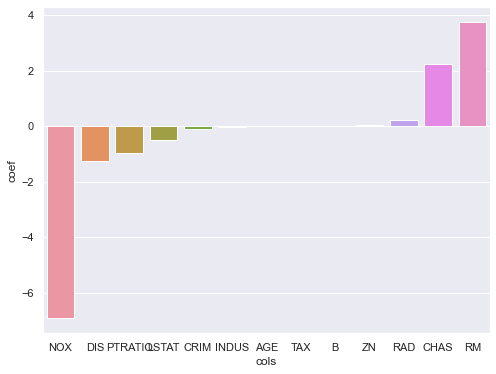

--------------------------------------------------
a         = 2
rmse      = 5.885952599498354
intercept = 31.26301511894806
            0         1         2         3         4         5         6   \
cols      CRIM        ZN     INDUS      CHAS       NOX        RM       AGE   
coef -0.115885  0.046574 -0.034275  2.205588 -5.828904  3.749628 -0.012859   

            7         8         9         10        11       12  
cols       DIS       RAD       TAX   PTRATIO         B    LSTAT  
coef -1.242373  0.215013 -0.011762 -0.942959  0.008684 -0.50266  


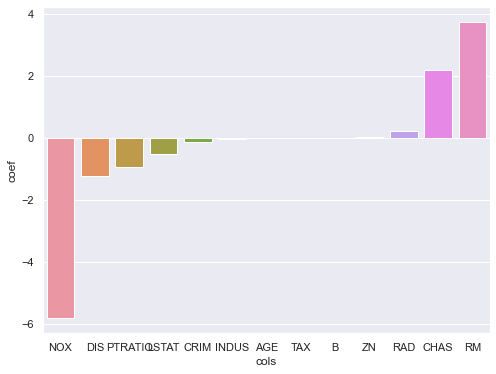

--------------------------------------------------
a         = 2.5
rmse      = 5.897565275110793
intercept = 30.830802081153372
           0         1         2         3         4        5         6   \
cols     CRIM        ZN     INDUS      CHAS       NOX       RM       AGE   
coef -0.11562  0.046782 -0.037353  2.169625 -5.028443  3.74096 -0.013517   

            7         8         9         10        11       12  
cols       DIS       RAD       TAX   PTRATIO         B    LSTAT  
coef -1.231484  0.213246 -0.011845 -0.935633  0.008725 -0.50429  


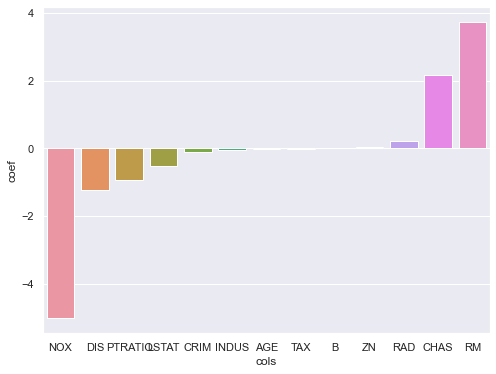

--------------------------------------------------
a         = 3
rmse      = 5.906848213927269
intercept = 30.536816760687714
            0         1         2         3         4         5         6   \
cols      CRIM        ZN     INDUS      CHAS       NOX        RM       AGE   
coef -0.115422  0.046963 -0.039685  2.134386 -4.421813  3.730326 -0.013982   

            7         8         9         10        11       12  
cols       DIS       RAD       TAX   PTRATIO         B    LSTAT  
coef -1.223326  0.212069 -0.011915 -0.930304  0.008756 -0.50582  


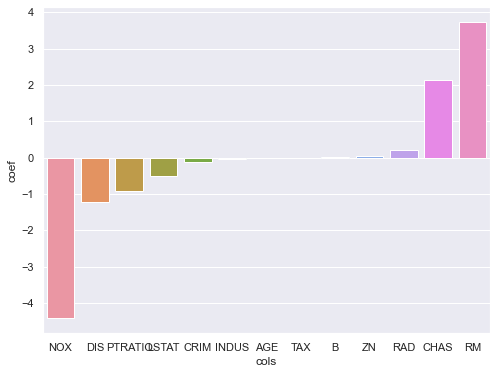

In [25]:
alphas =[0, 0.01, 0.1, 1, 1.5, 2, 2.5, 3]

for a in alphas:
    
    print('-' * 50)
    model = Ridge(alpha=a, normalize=False, max_iter=1000, random_state=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print('a         =', a)
    print('rmse      =', rmse)
    print('intercept =',model.intercept_)
    
    coef = model.coef_  # classification의 feature_importances_
    coef_df = pd.DataFrame({'cols':X_train.columns, 'coef':coef})
    
    print(coef_df.T)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(data=coef_df.sort_values(by='coef'), x='cols', y='coef')
    plt.show()

# ensemble

In [26]:
# 이론상으로는 강한 소수의 모델들보다, 약한 다수의 모델이 나음
# 현실은 강한 다수의 모델 사용
# 강한 모델들은 하나만 사용하더라도, 오버피팅 나기 쉬움
# 하지만, 공모전에서는 새로운 데이터를 받을 수 없는 제약
# 모델마다 같은 답변이 아니라, 다른 답변을 낼 때 사용
# 강한 모델들로 앙상블할 때는 점수가 좋은 쪽으로 가중치 조정

In [27]:
# bootstrap : 앙상블의 샘플 추출 방법
# .632 법칙 : 63%는 새로운 데이터, 37%는 중복 추출됨. 오버피팅 피할 수 있는 방법
# out-of-bag error : 학습되지 않은 데이터로 테스트

# voting   : 투표.
# bagging  : bootstrap으로 샘플을 뽑고, 각 샘플의 dt들을 앙상블
# boosting : 

In [28]:
# voting : 일반적으로 default soft

# 1. hard voting : 다수결 투표. 공정하지만, 좋지 않음.
# 애매한 여러 모델의 예측을 반영하기 때문에, 확실한 예측을 반영하지 못함

# 2. soft voting : 각 레이블 예측 확률의 평균으로 분류
# proba를 반영한 평균

In [29]:
# bagging : 복원 랜덤 샘플링 후 하나의 모델을 다양하게 학습
# 데이터(복원 추출된)만 다르고, 동일한 모델을 사용
# kfold와 유사한 방식
# ex. RandomForest : 동일한 tree 모델에, 다른 데이터 학습
# train_test 나눴기 때문에, out-of-bag=

In [30]:
# boosting : 하나의 트리를 순차적으로 가중치를 업데이트하여 업그레이드
# 약한 모델에는 가중치를 적게, 강한 모델에는 가중치를 크게 줘서 업그레이드
# 정보량/엔트로피가 높은 모델에 높은 가중치를 부여
# 한번 부트스트랩한 데이터를 사용
# 사용할 수록 max_depth가 작아짐. 보통은 커질수록 오버피팅남.
# 반복될 수록, 약한 가지들이 쳐내져서, 깊이가 적어도 시간도 절약되고, 점수가 잘 나옴.
# n_estimator마다 부트스트랩
# 그러나 매개변수 튜닝이 많이 필요.

# bagging이 일반적 모델, boosting은 맞추기 어려운 문제를 맞추려 노력

## voting

In [31]:
from sklearn.ensemble import VotingClassifier, VotingRegressor
# CatBoostClassifier()

lr = LinearRegression(fit_intercept=True, normalize=False)
dtr   = DecisionTreeRegressor()
rfr = RandomForestRegressor(
                            n_estimators=100, 
                            # criterion='rmse',
                            min_samples_leaf=1,
                            bootstrap=True,
                            oob_score=False, # out-of-bag
                            random_state=0,
                            )

# boosting 계열은 sample 3000 이상 권장
xgbr  = XGBRegressor()
lgbmr = LGBMRegressor()
cbr   = CatBoostRegressor(verbose=False)

# hard voting
vr = VotingRegressor(estimators=[
                                #  ('LinearRegression', lr),
                                #  ('DecisionTreeRegressor', dtr),
                                #  ('Lasso', lasso_model),
                                #  ('Ridge', ridge_model),
                                 ('RandomForestRegressor', rfr),
                                 ('XGBRegressor', xgbr), 
                                 ('LGBMRegressor', lgbmr), 
                                 ('CatBoostRegressor', cbr),
                                 ],
                     verbose=True,
                    #  weights=[0.3, 0.7], # threshold 조정과 유사, 가중치 조정
                     )

vr.fit(X_train, y_train)    # out-of-bag이 없기 때문에 X_train, y_train
y_pred = vr.predict(X_test) # forest만 out-of-bag 있음
mse  = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

[Voting] .... (1 of 4) Processing RandomForestRegressor, total=   0.3s
[Voting] ............. (2 of 4) Processing XGBRegressor, total=   0.1s
[Voting] ............ (3 of 4) Processing LGBMRegressor, total=   0.1s
[Voting] ........ (4 of 4) Processing CatBoostRegressor, total=   4.3s
21.215347574104573 4.606012111806109


## bagging

In [32]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(
                      base_estimator=xgbr,
                      n_estimators=10,
                      max_samples=1.0,
                      max_features=1.0,
                      bootstrap=True,
                      bootstrap_features=False, # 중요도가 높은 feature
                      oob_score=False,          # out-of-bag
                      warm_start=False,
                      n_jobs=None,
                      random_state=0,
                      verbose=0,
                      )

br.fit(X_train, y_train)
y_pred = br.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

21.73602092667661 4.662190571681579


## boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

# DecisionTreeRegressor를 강화하며 학습
gbr = GradientBoostingRegressor( 
                                loss='ls', 
                                learning_rate=0.1, 
                                n_estimators=100,
                                subsample=1.0, 
                                criterion='friedman_mse', 
                                random_state=0,
                                alpha=0.9, 
                                verbose=0, 
                                )

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)
print(mse, rmse, r2)

17.774577313016604 4.2159906680419255 0.7817153623747479


# pipeline

In [34]:
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(
                    #  StandardScaler(), 
                     GradientBoostingRegressor(),
                     verbose=True,
                     )

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

[Pipeline]  (step 1 of 1) Processing gradientboostingregressor, total=   0.1s


0.7817737932200645

# practices

In [35]:
import numpy as np
from sklearn.datasets import make_blobs

np.random.seed(0)

X, y = make_blobs(n_samples=2000, n_features=2, centers=3, random_state=42,
                  cluster_std=5.0)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:1000], y[600:1000]
X_train_valid, y_train_valid = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)

RandomForestClassifier(n_estimators=25)

In [37]:
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid, y_valid)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=25),
                       cv='prefit')

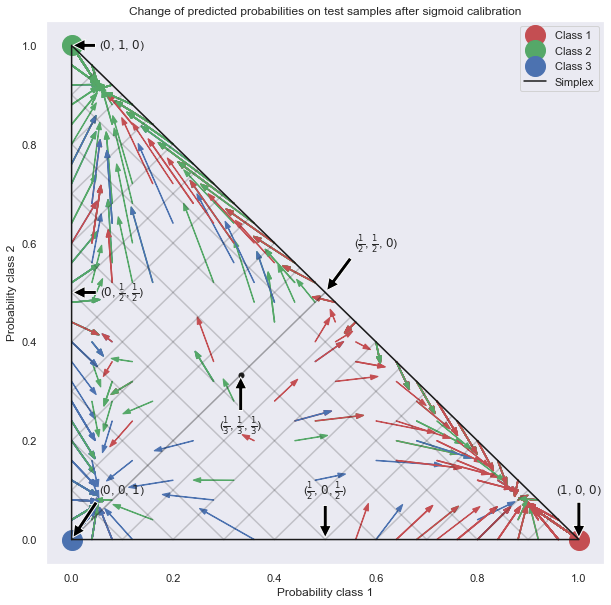

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
colors = ["r", "g", "b"]

clf_probs = clf.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
              cal_clf_probs[i, 0] - clf_probs[i, 0],
              cal_clf_probs[i, 1] - clf_probs[i, 1],
              color=colors[y_test[i]], head_width=1e-2)

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], 'ro', ms=20, label="Class 1")
plt.plot([0.0], [1.0], 'go', ms=20, label="Class 2")
plt.plot([0.0], [0.0], 'bo', ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(r'($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)',
             xy=(1.0/3, 1.0/3), xytext=(1.0/3, .23), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.plot([1.0/3], [1.0/3], 'ko', ms=5)
plt.annotate(r'($\frac{1}{2}$, $0$, $\frac{1}{2}$)',
             xy=(.5, .0), xytext=(.5, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $\frac{1}{2}$, $\frac{1}{2}$)',
             xy=(.0, .5), xytext=(.1, .5), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($\frac{1}{2}$, $\frac{1}{2}$, $0$)',
             xy=(.5, .5), xytext=(.6, .6), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $0$, $1$)',
             xy=(0, 0), xytext=(.1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($1$, $0$, $0$)',
             xy=(1, 0), xytext=(1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $1$, $0$)',
             xy=(0, 1), xytext=(.1, 1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Change of predicted probabilities on test samples "
          "after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

In [39]:
from sklearn.metrics import log_loss

score = log_loss(y_test, clf_probs)
cal_score = log_loss(y_test, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 1.290
 * calibrated classifier: 0.549


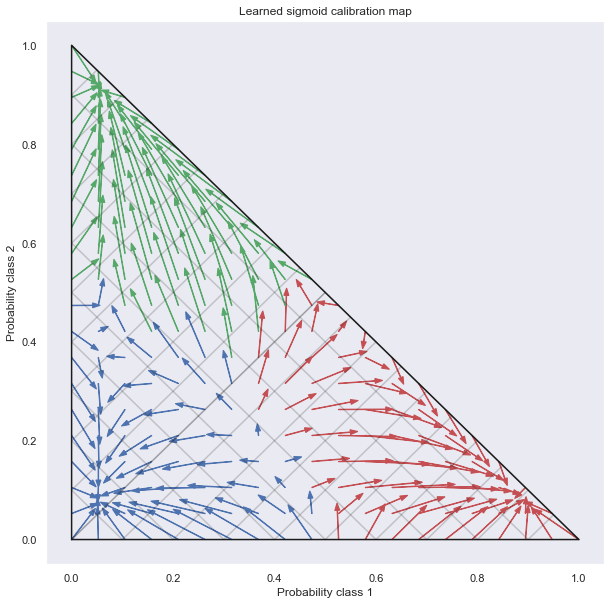

In [40]:
plt.figure(figsize=(10, 10))
# Generate grid of probability values
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

# Use the three class-wise calibrators to compute calibrated probabilities
calibrated_classifier = cal_clf.calibrated_classifiers_[0]
prediction = np.vstack([calibrator.predict(this_p)
                        for calibrator, this_p in
                        zip(calibrated_classifier.calibrators, p.T)]).T

# Re-normalize the calibrated predictions to make sure they stay inside the
# simplex. This same renormalization step is performed internally by the
# predict method of CalibratedClassifierCV on multiclass problems.
prediction /= prediction.sum(axis=1)[:, None]

# Plot changes in predicted probabilities induced by the calibrators
for i in range(prediction.shape[0]):
    plt.arrow(p[i, 0], p[i, 1],
              prediction[i, 0] - p[i, 0], prediction[i, 1] - p[i, 1],
              head_width=1e-2, color=colors[np.argmax(p[i])])

# Plot the boundaries of the unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Learned sigmoid calibration map")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()

In [41]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

np.random.seed(0)
X, y = load_iris(return_X_y=True)
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

train_scores, valid_scores = validation_curve(Ridge(), X, y, "alpha",
                                              np.logspace(-7, 3, 3),
                                              cv=5)
train_scores

array([[0.93402178, 0.94366418, 0.92648383, 0.91933313, 0.92922507],
       [0.9340217 , 0.94366412, 0.92648377, 0.91933304, 0.929225  ],
       [0.51143526, 0.52415737, 0.49868907, 0.47086988, 0.49623503]])

In [42]:
valid_scores


array([[0.9055033 , 0.84185935, 0.94569793, 0.96231017, 0.93366144],
       [0.90550088, 0.84184574, 0.94568969, 0.96233172, 0.93366806],
       [0.46706558, 0.25698974, 0.50496293, 0.49826404, 0.52500014]])

In [43]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(
    SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)
train_sizes

array([ 50,  80, 110])

In [44]:
train_scores

array([[0.98      , 0.98      , 0.98      , 0.98      , 0.98      ],
       [0.9875    , 1.        , 0.9875    , 0.9875    , 0.9875    ],
       [0.98181818, 1.        , 0.98181818, 0.98181818, 0.99090909]])

In [45]:
valid_scores

array([[1.        , 0.93333333, 1.        , 1.        , 0.96666667],
       [1.        , 0.96666667, 1.        , 1.        , 0.96666667],
       [1.        , 0.96666667, 1.        , 1.        , 0.96666667]])